# Just don't use this.


In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

from sklearn.preprocessing import MultiLabelBinarizer


# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [122]:
# load the data from the xlsx file
from pathlib import Path

p = Path('/Users/david/projects/lc2-1028/')
# fn = "Biospecimen-Data-FINAL-n-1028-2024-07-18.xlsx"

# fn = "Biospecimen-Data-TIME-CORRECTED-FINAL-n-1028-2024-07-23.xlsx"
# fn = "Biospecimen-Data-TIME-CORRECTED-FINAL-n-1028-2024-07-25.xlsx"

# fn = "Biospecimen-Corrected-Clean-Data-FINAL-n-1028-2024-07-25.xlsx"
fn = "2024-08-02-data-timeseries.xlsx"

df = pd.read_excel(str(p / fn), header = 0, engine='openpyxl')

df

,record_id,RedCAP Record ID Check,FINAL_Match_Num,sex,gender,age,home_location,living_with,country,employed,...,datetime_collection,Days_Onset-Collect,Confirmed_Days_Onset-Collect,Months_Post_Onset_30.44,datetime_freezing,aliquots,biospecimen_collection_not,biospecimen_used___1,matchnumber,biospecimen_complete
0,1.0,1.0,273.0,1.0,MALE,47.0,1.0,3.0,42.0,1.0,...,2023-12-15 15:10:00,226.0,226.0,7.424442,2023-12-15 15:36:00,H,"Sample lipemic TV = 6 x 250uL (A-F), 2 x 500u...",1.0,NaN,2.0
1,2.0,2.0,184.0,2.0,NaN,37.0,1.0,1.0,16.0,0.0,...,2023-12-18 08:15:00,267.0,267.0,8.771353,2023-12-18 08:56:00,H,4 x 250uL (A-D) 4 x 500uL (E-H),1.0,NaN,2.0
2,3.0,3.0,185.0,2.0,FEMALE,54.0,1.0,1.0,16.0,1.0,...,2023-12-18 08:40:00,266.0,266.0,8.738502,2023-12-18 09:05:00,H,5 x 250uL (A-E) 3 x 500uL (F-H),1.0,NaN,2.0
3,4.0,4.0,274.0,1.0,NaN,78.0,1.0,1.0,62.0,0.0,...,2024-01-05 13:34:00,1018.0,1018.0,33.442838,2024-01-05 14:28:00,G,NaN,1.0,NaN,2.0
4,5.0,5.0,275.0,2.0,FEMALE,33.0,1.0,1.0,16.0,1.0,...,2024-01-05 14:03:00,1101.0,1101.0,36.169514,2024-01-05 14:55:00,G,"No Sample ""E""",1.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,6119.0,6119.0,221.0,2.0,NaN,69.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,1.0,NaN,2.0
1025,6120.0,6120.0,251.0,2.0,NaN,31.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,1.0,NaN,2.0
1026,6121.0,6121.0,108.0,2.0,NaN,26.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,1.0,NaN,2.0
1027,6122.0,6122.0,186.0,2.0,NaN,45.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,1.0,NaN,2.0


In [123]:
# drop the last row which is a set of totals
df = df.drop(df.index[-1])

In [124]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = deepcopy(df)
preserved_df.shape

(1028, 782)

In [125]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [7]:
df = preserved_df

In [8]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Columns: 782 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](15), float64(676), int64(80), object(11)
memory usage: 6.1+ MB


In [9]:
# A list of columns to drop
to_drop = []

In [10]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx_4', 'other_hhx_5', 'other_hhx_6', 'other_hhx_7', 'other_hhx_8', 'other_hhx_9', 'medication6', 'medication7', 'medication8', 'medication9', 'medication10', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'troponint', 'echoresult', 'ekgresult', 'ekgcode', 'cxrresult', 'cxrcode', 'ctaresult', 'cttresult', 'cthresult', 'spirometryresult', 'lung_functionresult', 'vac_sideeffect4', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload', 'matchnumber']


In [11]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                179
MALE                  132
Femenino                5
Masculino               4
Male                    2
TRANSGENDER FEMALE      1
Female                  1
Msculino                1
Name: count, dtype: int64
Nulls = 703


In [12]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# # info on the adjunctive columns
# print(preserved_df[adj_cols].info())
# print(preserved_df[adj_cols].describe())
# print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

In [13]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 48 columns


['other_hhx_4',
 'other_hhx_5',
 'other_hhx_6',
 'other_hhx_7',
 'other_hhx_8',
 'other_hhx_9',
 'medication6',
 'medication7',
 'medication8',
 'medication9',
 'medication10',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'troponint',
 'echoresult',
 'ekgresult',
 'ekgcode',
 'cxrresult',
 'cxrcode',
 'ctaresult',
 'cttresult',
 'cthresult',
 'spirometryresult',
 'lung_functionresult',
 'vac_sideeffect4',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'matchnumber',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [14]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(1028, 734)

In [15]:
# get all column names
df_columns = df.columns

## TODO

In [16]:
# TODO: one-hot encode mode of diag


df["mode_of_diag"].value_counts()

mode_of_diag
1.0    680
2.0    200
5.0     17
3.0      1
Name: count, dtype: int64

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [17]:
# # LC_positive types
# pos_vals = [2,4,6,8,9,12,13]
# neg_vals = [1,5,7,10,]
# hc_vals  = [3,11, 14,15]

# LC_pos = df.query('participant_type in @pos_vals')
# LC_neg = df.query('participant_type in @neg_vals')
# HC     = df.query('participant_type in @hc_vals')


# df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

# rename LC_Status to LC_STATUS
df = df.rename(columns = {'LC_Status': 'LC_STATUS'})


print(df['LC_STATUS'].value_counts())

# LC_pos is the set with LC_STATUS == 1
LC_pos = df.query('LC_STATUS == 1')
LC_neg = df.query('LC_STATUS == 0')
HC     = df.query('LC_STATUS == 2')

LC_STATUS
1.0    494
0.0    494
2.0     40
Name: count, dtype: int64


In [18]:
# keep only the LC+ rows
# df = LC_pos
df.shape

(1028, 734)

## DEMOGRAPHICS

In [19]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(1028, 5)

In [20]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     1028 non-null   float64
 1   age     1028 non-null   float64
 2   hcp     949 non-null    float64
 3   micro   946 non-null    float64
 4   dag     1028 non-null   float64
dtypes: float64(5)
memory usage: 40.3 KB


In [21]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,0,0
age,0,0,0,0,0
hcp,16,6,0,56,1
micro,17,6,0,58,1
dag,0,0,0,0,0


In [22]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_36983/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(1028, 3)

### SITES

- summary of LC status by site
- not a feature set
- information only

In [23]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,0.0,1.0,2.0
dag,,,
LDN,1,29,16
MTL,321,293,0
SAN,26,26,0
RIO,29,29,8
LUS,117,117,16


In [24]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    614
LUS    250
RIO     66
SAN     52
LDN     46
Name: count, dtype: int64

In [25]:
# # get the range of indices for each site
# site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

# site_ranges.sort_values()

## SUBSTANCE USE

In [26]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]

# fill na with 0
# substance_features = substance_features.fillna(0)

In [27]:
substance_features.sum(axis = 0)

SUBST-1    185.0
SUBST-2     17.0
SUBST-3    132.0
SUBST-4     37.0
SUBST-5      3.0
dtype: float64

In [28]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      1.0      0.0      0.0      0.0
 1      1.0      0.0      0.0      0.0      0.0
 2      0.0      0.0      0.0      0.0      0.0
 3      0.0      0.0      0.0      0.0      0.0
 4      0.0      0.0      1.0      0.0      0.0,
 (1028, 5))

In [29]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,0,0,0,0,0
substances___2,0,0,0,0,0
substances___3,0,0,0,0,0
substances___4,0,0,0,0,0
substances___5,0,0,0,0,0


<Axes: >

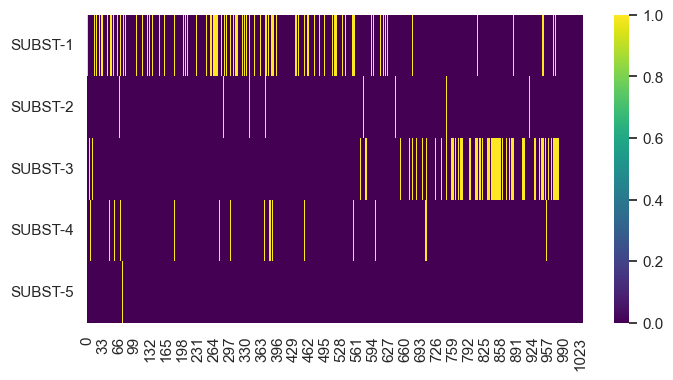

In [30]:
# sns heatmap of the substances
plt.figure(figsize = (8,4))

sns.heatmap(substance_features.T, cmap = 'viridis', annot = False)

## MEDICATIONS
 - one hot encode

In [31]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1', 'medication2', 'medication3', 'medication4', 'medication5']

In [32]:
# what is the dtype in each column in MEDTEMP?
df[MEDTEMP].dtypes

df[MEDTEMP].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   medication1  121 non-null    float64
 1   medication2  47 non-null     float64
 2   medication3  18 non-null     float64
 3   medication4  9 non-null      float64
 4   medication5  3 non-null      float64
dtypes: float64(5)
memory usage: 40.3 KB


In [33]:
# read medications dict from json
import json

with open("../OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [34]:

med_df = pd.DataFrame()

print(">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      21 NEW columns
>>> 	- will remove    5 OLD columns
>>> 	- net change    16 columns
(1028, 21)


In [35]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

medication_features.shape

(1028, 20)

## HEALTH HISTORY

### Patient History

In [36]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [37]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("../OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [38]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,2,100,9,0,31
past_hhx___2,1,0,2,0,0
past_hhx___3,1,29,6,1,5
past_hhx___4,0,36,12,4,5
past_hhx___5,2,33,2,1,0
past_hhx___6,3,23,0,0,1
past_hhx___7,1,26,2,0,0
past_hhx___8,1,19,4,0,1
past_hhx___9,0,0,1,0,0
past_hhx___10,0,15,1,0,2


In [40]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,0,0,0,0,0
past_hhx___2,0,0,0,0,0
past_hhx___3,0,0,0,0,0
past_hhx___4,0,0,0,0,0
past_hhx___5,0,0,0,0,0
past_hhx___6,0,0,0,0,0
past_hhx___7,0,0,0,0,0
past_hhx___8,0,0,0,0,0
past_hhx___9,0,0,0,0,0
past_hhx___10,0,0,0,0,0


### One-hot encode `other_hhx`


In [41]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx_2', 'other_hhx_3']

In [42]:
df[OTHER_HHX_TEMP]

,other_hhx,other_hhx_2,other_hhx_3
0,5.0,NaN,NaN
1,NaN,NaN,NaN
2,3.0,NaN,NaN
3,24.0,5.0,NaN
4,NaN,NaN,NaN
...,...,...,...
1023,NaN,NaN,NaN
1024,NaN,NaN,NaN
1025,NaN,NaN,NaN
1026,NaN,NaN,NaN


In [43]:
# read the other-hhx dict from json
import json

with open("../OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


In [44]:
# # use the other_hx_dict to rename the columns
# t1 = df[OTHER_HHX_TEMP]

# for c in t1.columns:

#     t1[c] = t1[c].map(other_hx_dict).fillna(0)

In [45]:
# use a multilabel binarizer to encode the values
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index

a = df[OTHER_HHX_TEMP].fillna(0).values
# a = t1.fillna(0).values

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [46]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,HHX-OTHER-BPH,HHX-OTHER-OB,HHX-OTHER-resp,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-surgery
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1025,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# use get_dummies to one0hot encode the other_hhx column
# this assigns nans a value of zero by default.
# turning on the dummy_na flag will create a separate column for nans
# we would want to drop that column as it is not useful
# QUESTION: when taking a patient's history, is it safe to assume that they were asked "do you have any other health issues?" and if there is no response, the answer is "no"?

# this is only useful for a single column
# there are 4 cols of other_hhx, so we use the same method as for meds above.

# other_hhx_features = pd.get_dummies(
#                                     # df["other_hhx"], 
#                                     # columns = ["other_hhx"], 
#                                     df[OTHER_HHX_TEMP], 
#                                     columns = OTHER_HHX_TEMP, 
#                                     prefix = "OTHER-HHX", 
#                                     prefix_sep = "-", 
#                                     dtype = int, 
#                                     # dummy_na = True
#                                     )

# print(other_hhx_features.shape)

In [48]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0
HHX-OTHER-BPH,0,0,0,0,0


### Concatenate health history

In [49]:
# concatenate the health hx features with the other health hx features

# sort hhx_df columns
hhx_df = hhx_df.reindex(sorted(hhx_df.columns), axis=1)

# sort other_hhx_features columns
other_hhx_features = other_hhx_features.reindex(sorted(other_hhx_features.columns), axis=1)

# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [50]:

# # sort alphabetically
# hx_features_all = hx_features_all.reindex(sorted(hx_features_all.columns), axis = 1)




In [51]:

# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


There are 698 missing values in the global health column


Text(0.5, 1.0, 'Health History Features')

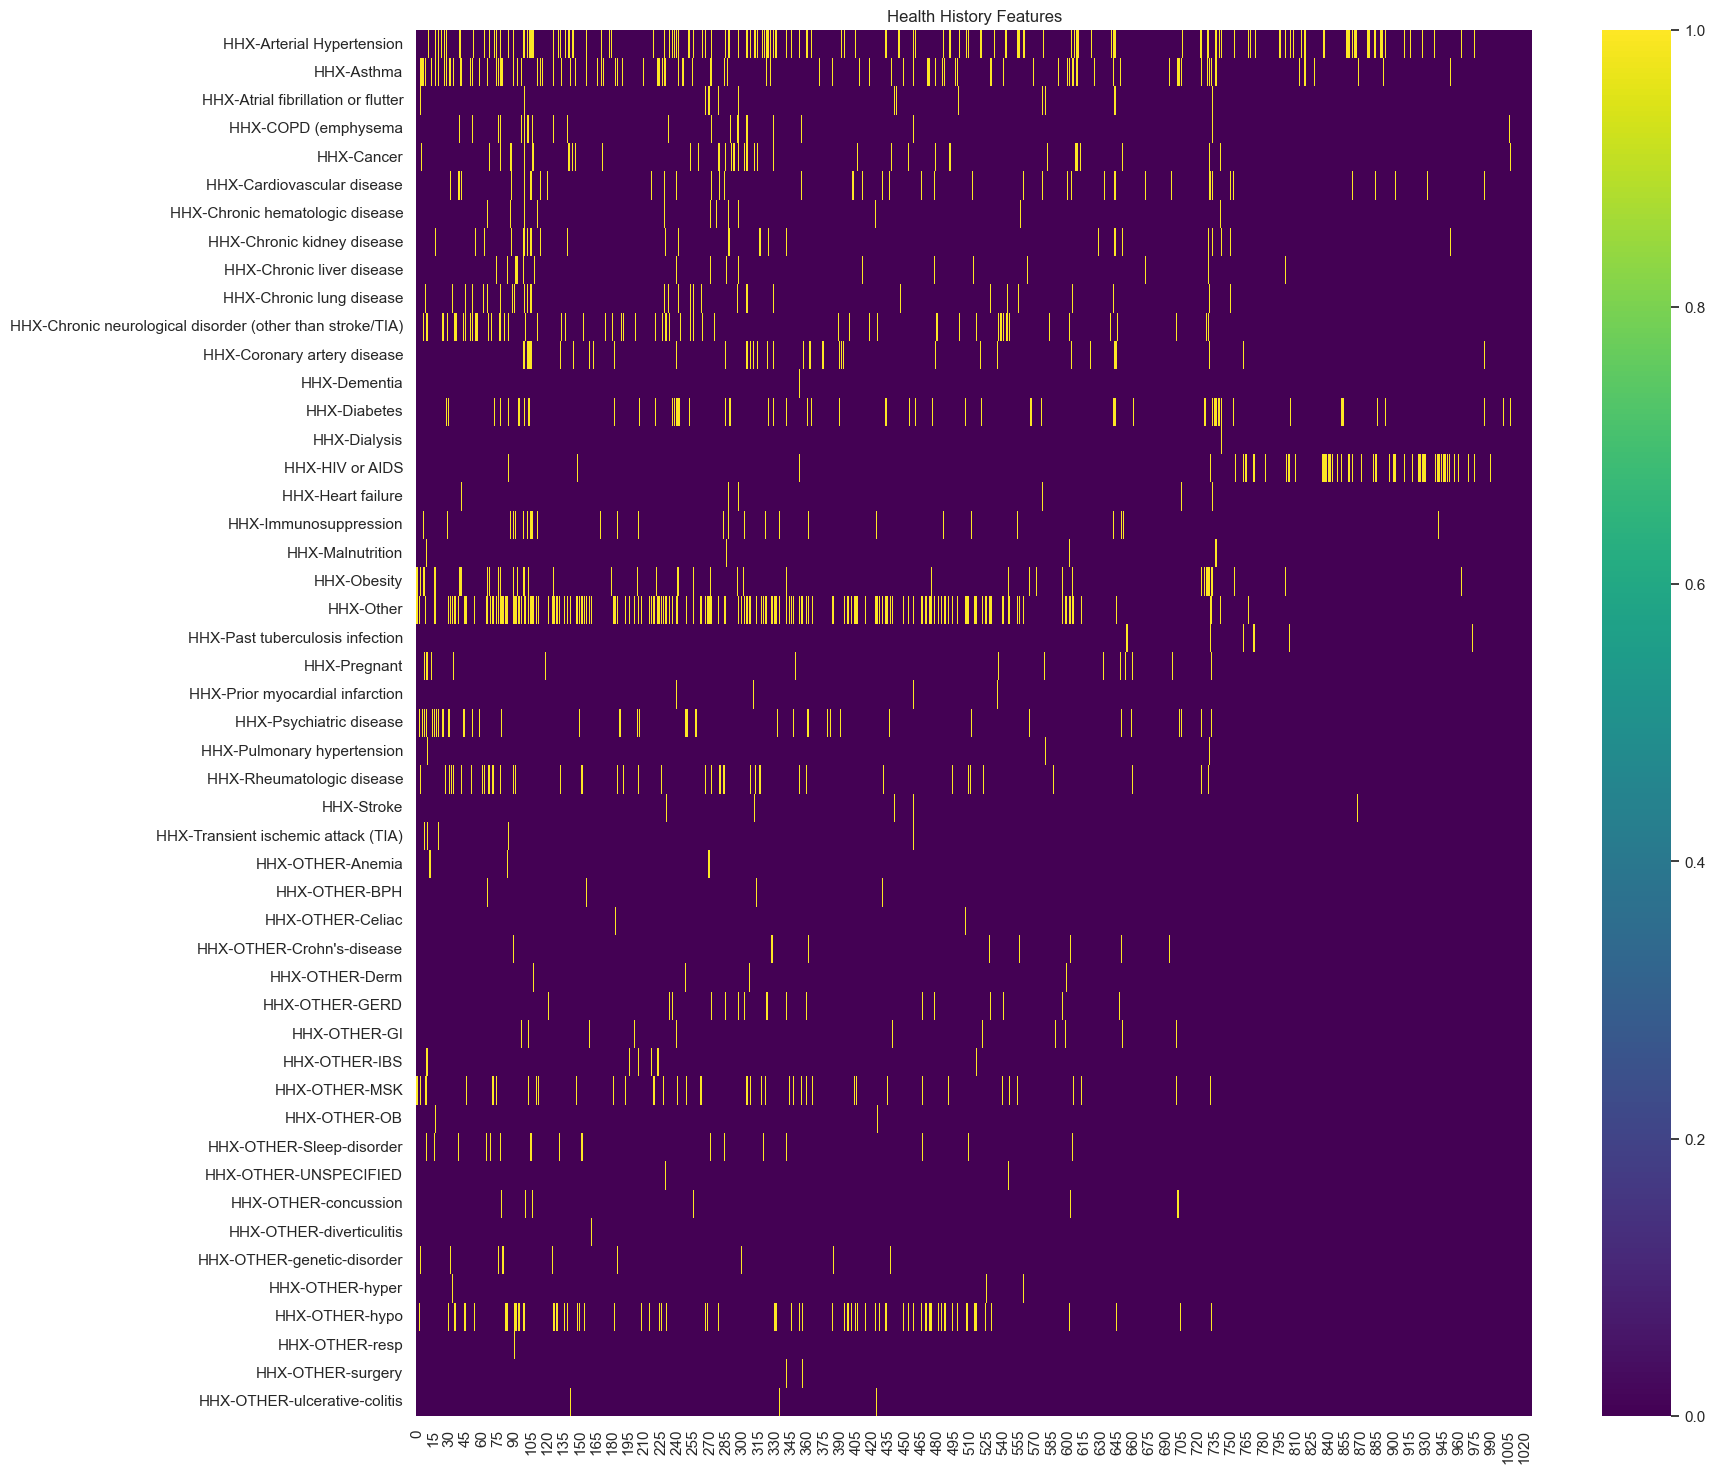

In [52]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SYMPTOMS

In [53]:
# read the list of symtpoms from the json file
import json
with open("../OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1)

symptom_features.shape

(1028, 56)

In [54]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
# df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


<Axes: >

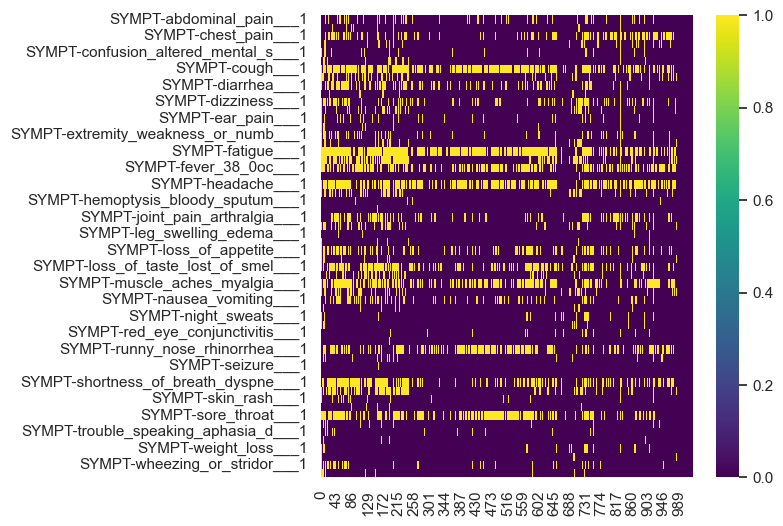

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [56]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

In [57]:
# remove columns that have less than 200 non-null points
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if df[col].count() > 200]

### Investigate some of the features

In [58]:

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]


In [59]:
# count items that start with ct
df.filter(regex='^ct', axis = 1).count()

cta    289
ctt    300
cth    289
dtype: int64

In [60]:
# df["ctaresult"].value_counts()
# df["cttresult"].value_counts()
# df["cthresult"].value_counts()

In [61]:
# CTA, CTT, CTH - most of the results are 2 - no report
# CONCLUSION: recommend dropping these - there are very few discriminant results

In [62]:
# count items that start with ct
df.filter(regex='^cx', axis = 1).count()

cxr    293
dtype: int64

In [63]:
# count cxr code values
# df["cxrresult"].value_counts()

# most are no-result. Of the 39 that are a positive finding, what are the results?

In [64]:
# df["cxrcode"].value_counts()

# 33 fluid, etc
# 3 fibrosis
# 2 nodules, cysts
# 2 congestive heart disease etc

In [65]:
# CONCLUSION: recommend dropping these too - very small numbers

In [66]:
# now echo
# count items that start with ct
df.filter(regex='^echo', axis = 1).count()

echocardiogram    296
dtype: int64

In [67]:
# df["echoresult"].value_counts()
# mostly no reports, 7 positive findings

In [68]:
# # finally, ekg
# print(df.filter(regex='^ekg', axis = 1).count())

# print(df["ekgresult"].value_counts())
# print(df["ekgcode"].value_counts())

# # ekgcode results indicate 
# # 10 sinus bradycardia
# # 2 atrioventricular block
# # 1 each of supraventricular, sinus tachy, infarction

# # CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# # numbers are very very small

In [69]:
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [70]:
# # count all values in features
# df[CLINICAL_TESTS].info()


In [71]:
# CONCLUSION SUMMARY
# drop cx*, ct*, echo*, ekg*, angiography, imaging, spiromoetry, lung_function, cd4, cd8, stented, tropinin, igg, 

In [72]:
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "lung_function", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           92 non-null     float64
 1   alt               106 non-null    float64
 2   aptt              46 non-null     float64
 3   ast               78 non-null     float64
 4   basophil          45 non-null     float64
 5   basophil_count    45 non-null     float64
 6   bilirubin         126 non-null    float64
 7   bilirubin_direct  35 non-null     float64
 8   cpk               55 non-null     float64
 9   creatinine        138 non-null    float64
 10  crp               98 non-null     float64
 11  eosinophil        44 non-null     float64
 12  eosinophil_count  47 non-null     float64
 13  ferritin          53 non-null     float64
 14  fibrinogen        51 non-null     float64
 15  glucose           94 non-null     float64
 16  haemoglobin       132 non-null    float64


Text(0.5, 1.0, 'Clinical Tests')

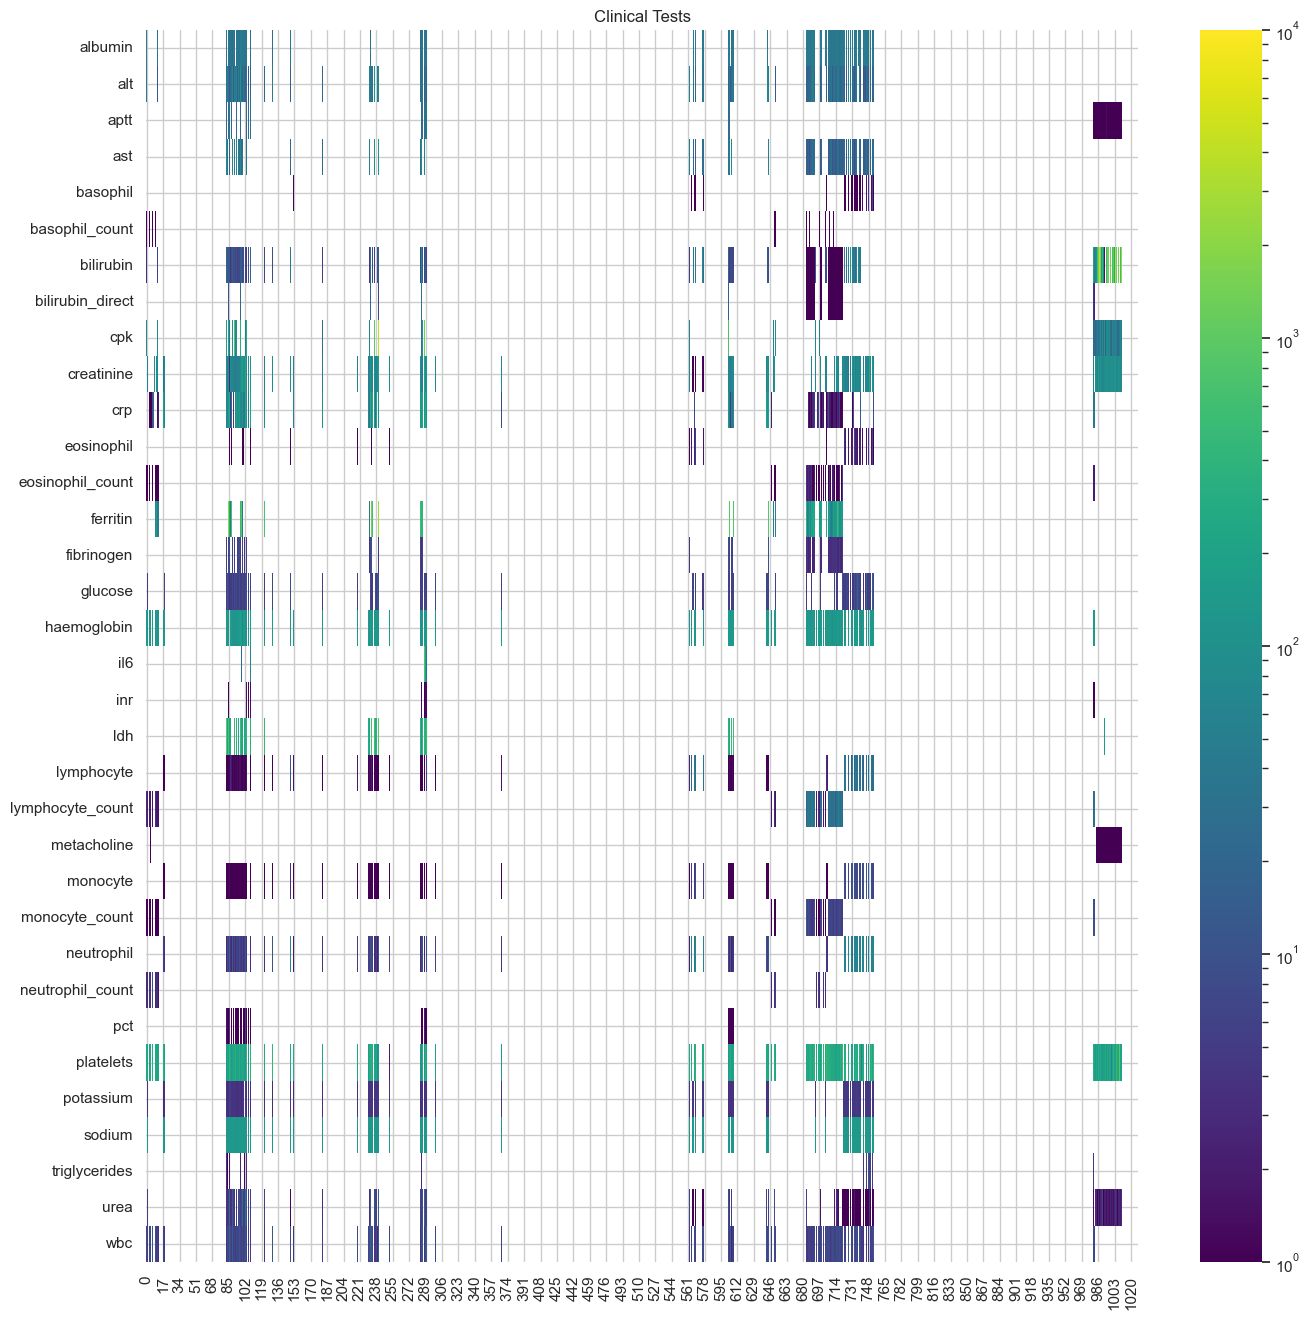

In [73]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
plt.title("Clinical Tests")

In [74]:
# how many nulls per site?
print("Missing CLINICAL values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing CLINICAL values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,42,580,25,39,250
alt,42,566,25,39,250
aptt,46,598,52,36,250
ast,46,590,25,39,250
basophil,44,594,29,66,250
basophil_count,28,614,52,39,250
bilirubin,41,568,34,9,250
bilirubin_direct,46,608,52,37,250
cpk,40,595,52,36,250
creatinine,37,555,19,29,250


In [75]:
# how many nulls by LC_STATUS?
print("Missing CLINICAL values by LC_STATUS:")
df.groupby('LC_STATUS')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).T.map(lambda x: f"{x:,}") # type: ignore

Missing CLINICAL values by LC_STATUS:


LC_STATUS,0.0,1.0,2.0
albumin,477,419,40
alt,476,406,40
aptt,461,481,40
ast,479,431,40
basophil,480,463,40
basophil_count,493,450,40
bilirubin,453,409,40
bilirubin_direct,493,460,40
cpk,462,471,40
creatinine,443,407,40


## CLINICAL DETAILS

In [76]:
# read the list of symtpoms from the json file
import json
with open("../OUTPUT/list-clin-details.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
CD = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
CD = [col for col in CD if not col.startswith(("phx", "phq"))]

# feature set for symptoms
cd_features = df[CD]

# preprend CLIN- to the column names
cd_features.columns = [f"CD-{col}" for col in cd_features.columns]

# find spaces in the data and replace with zero
cd_features = cd_features.replace(" ", 0)

In [77]:
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Columns: 320 entries, CD-pregnant to CD-o2_saturation
dtypes: datetime64[ns](9), float64(310), object(1)
memory usage: 2.5+ MB


In [78]:
# drop columns with dtype datetime64
cd_features = cd_features.select_dtypes(exclude = ['datetime64'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Columns: 311 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310), object(1)
memory usage: 2.4+ MB


In [79]:
# which cols are of type object?
cd_features.select_dtypes(include = ['object']).columns

Index(['CD-specify_other_med'], dtype='object')

In [80]:
# drop the object columns as they are either dates or mostly spaces
cd_features = cd_features.select_dtypes(exclude = ['object'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Columns: 310 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310)
memory usage: 2.4 MB


Text(0.5, 1.0, 'CLINICAL DETAIL Status- missing values are light coloured')

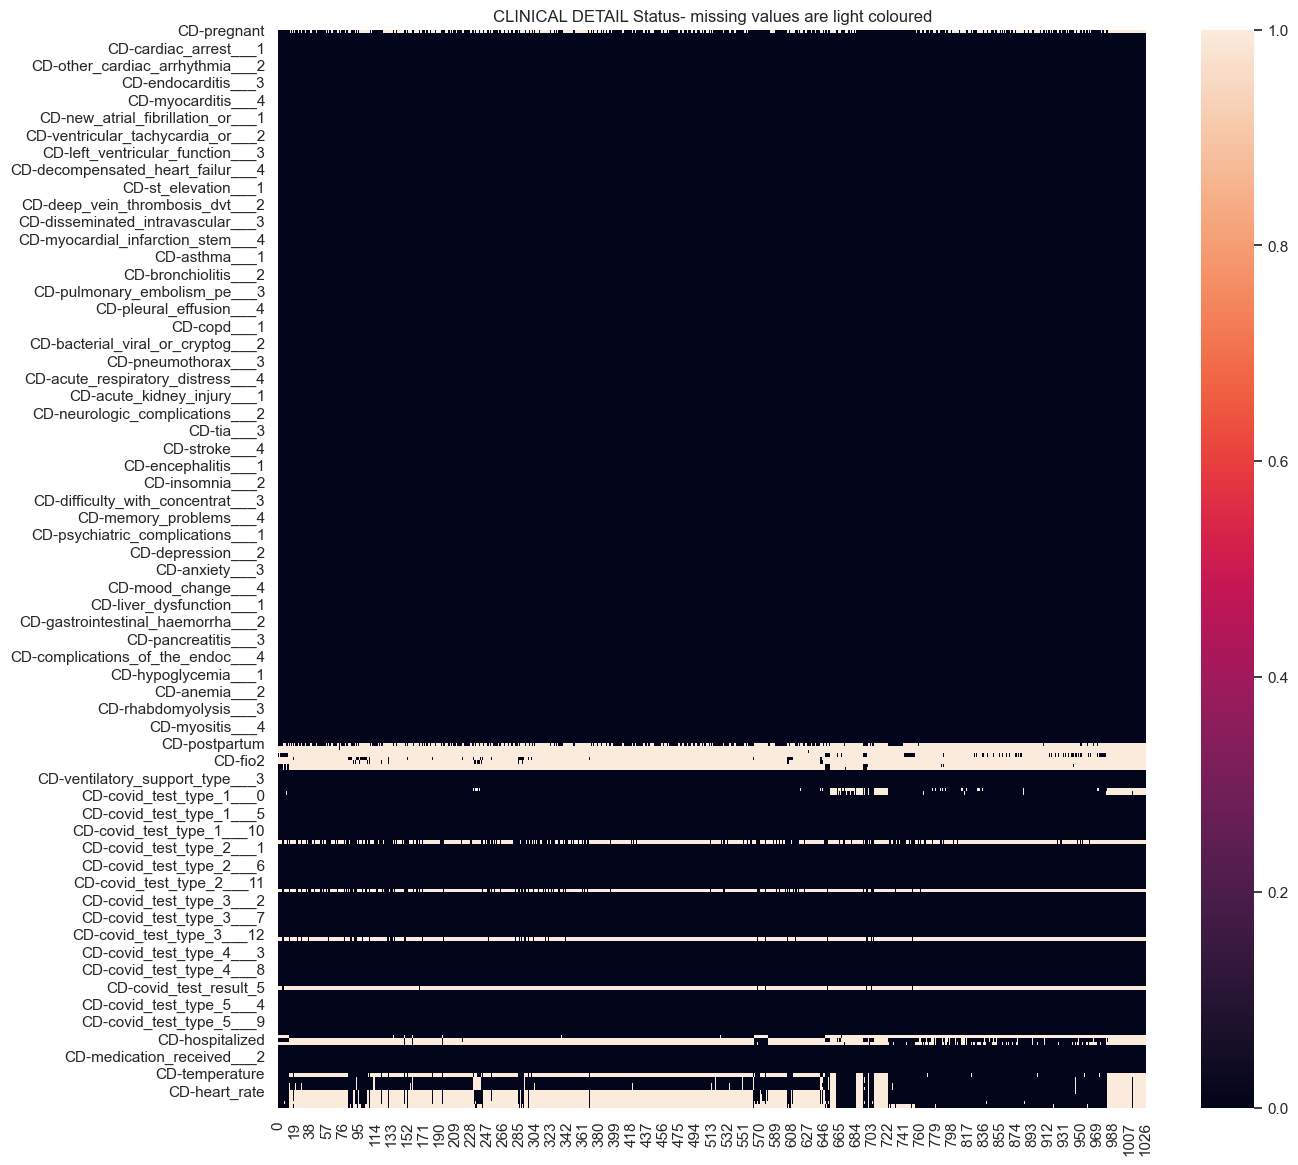

In [81]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status- missing values are light coloured")

In [82]:
# these features are not very informative - consider dropping them
cd_features = cd_features.drop(columns = cd_features.filter(like = "test_type").columns)

# height in metres and centimetres is redundant
# drop the height in cm
cd_features = cd_features.drop(columns = "CD-height_cm")

cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028 entries, 0 to 1027
Columns: 244 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(244)
memory usage: 1.9 MB


In [83]:
# sort alphabetically
cd_features = cd_features.reindex(sorted(cd_features.columns), axis=1)

Text(0.5, 1.0, 'CLINICAL DETAIL Status - missing values are light coloured')

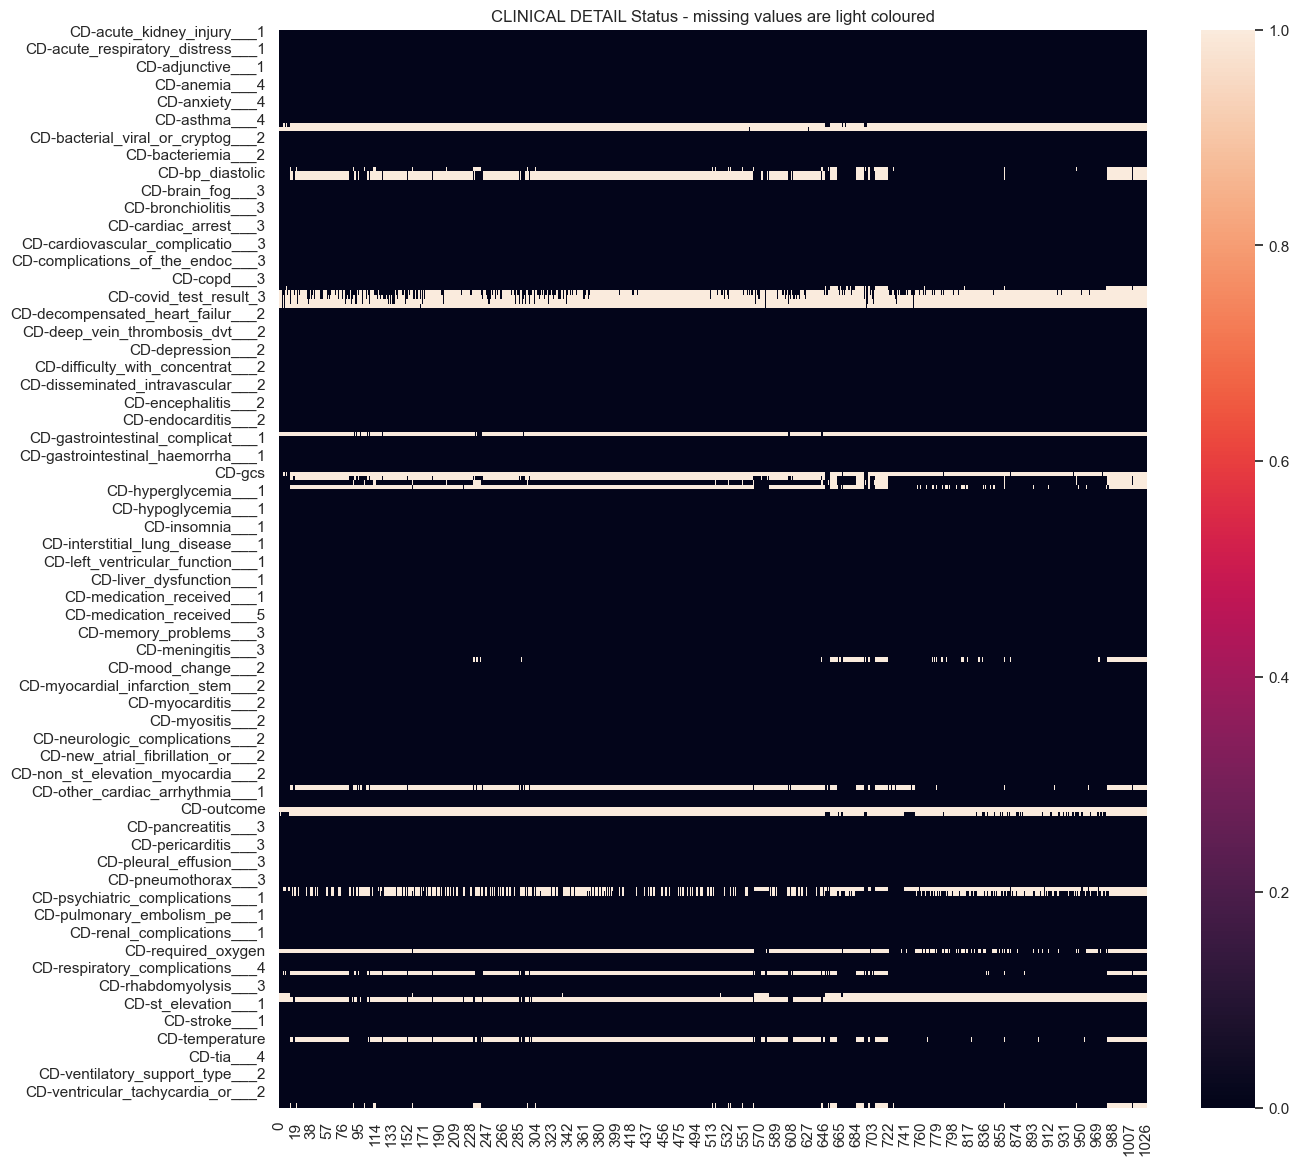

In [84]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status - missing values are light coloured")

In [85]:
# missing values by site
print("Missing CLINICAL DETAILS values by site:")

cd_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing CLINICAL DETAILS values by site:


dag
LDN      755
MTL    11649
SAN      685
RIO     1741
LUS     3520
dtype: int64

## VACCINES

In [86]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

# for now, select only vaccine status
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(1028, 1)


Text(0.5, 1.0, 'Vaccination Status - missing values are light coloured')

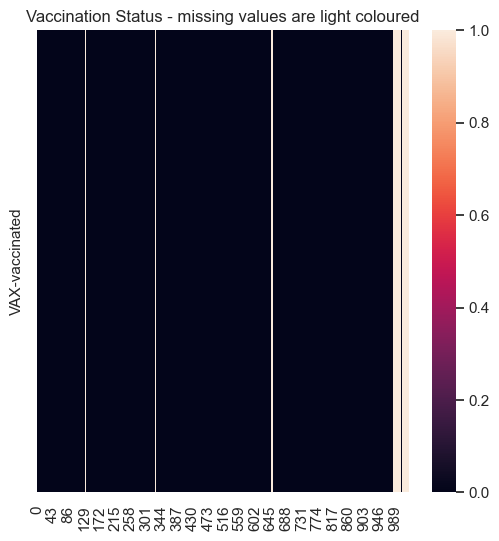

In [87]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
plt.title("Vaccination Status - missing values are light coloured")

In [88]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing VAX values by site:


dag,LDN,MTL,SAN,RIO,LUS
VAX-vaccinated,22,3,0,21,1


In [89]:
# # how many nulls per site?
# print("Missing VACCINE values by site:")
# df.groupby('dag')[VAX + VAX_STATUS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


### CONCLUSION:
- use only the vaccine status (binary)

# SAVE FEATURES TO FILE

In [90]:
# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

In [91]:
demographic_features.shape, substance_features.shape, medication_features.shape, hx_features_all.shape, symptom_features.shape, cd_features.shape, vax_features.shape

((1028, 3),
 (1028, 5),
 (1028, 20),
 (1028, 49),
 (1028, 56),
 (1028, 244),
 (1028, 1))

In [92]:
lbls = pd.DataFrame(df["Sample_Label_ID"])
## Features
lbls

,Sample_Label_ID
0,LDN-0001
1,LDN-0002
2,LDN-0003
3,LDN-0004
4,LDN-0005
...,...
1023,HC-0012
1024,HC-0013
1025,HC-0014
1026,HC-0015


In [93]:


# concatenate all of the features
features = pd.concat([
                        demographic_features, 
                        symptom_features, 
                        vax_features,
                        hx_features_all, 
                        cd_features,
                        # WIP: 
                        medication_features, 
                        lbls,
                        # substance_features, # not selected
                        # 
                        # NOT SELECTED:
                        # lab_features, - not enough data
                        # survey_features,    # not selected
                      ], axis = 1)

features["LC_STATUS"] = df["LC_STATUS"]

In [94]:
# list shapes of each feature set
for f in [demographic_features, symptom_features, vax_features, hx_features_all, cd_features, medication_features, substance_features]:
    print(f.shape)

(1028, 3)
(1028, 56)
(1028, 1)
(1028, 49)
(1028, 244)
(1028, 20)
(1028, 5)


In [95]:
features.shape

(1028, 375)

In [96]:
# # count the nulls per site
# print("Missing values by site:")

# features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Text(0.5, 1.0, 'Missing values - light coloured cells are missing')

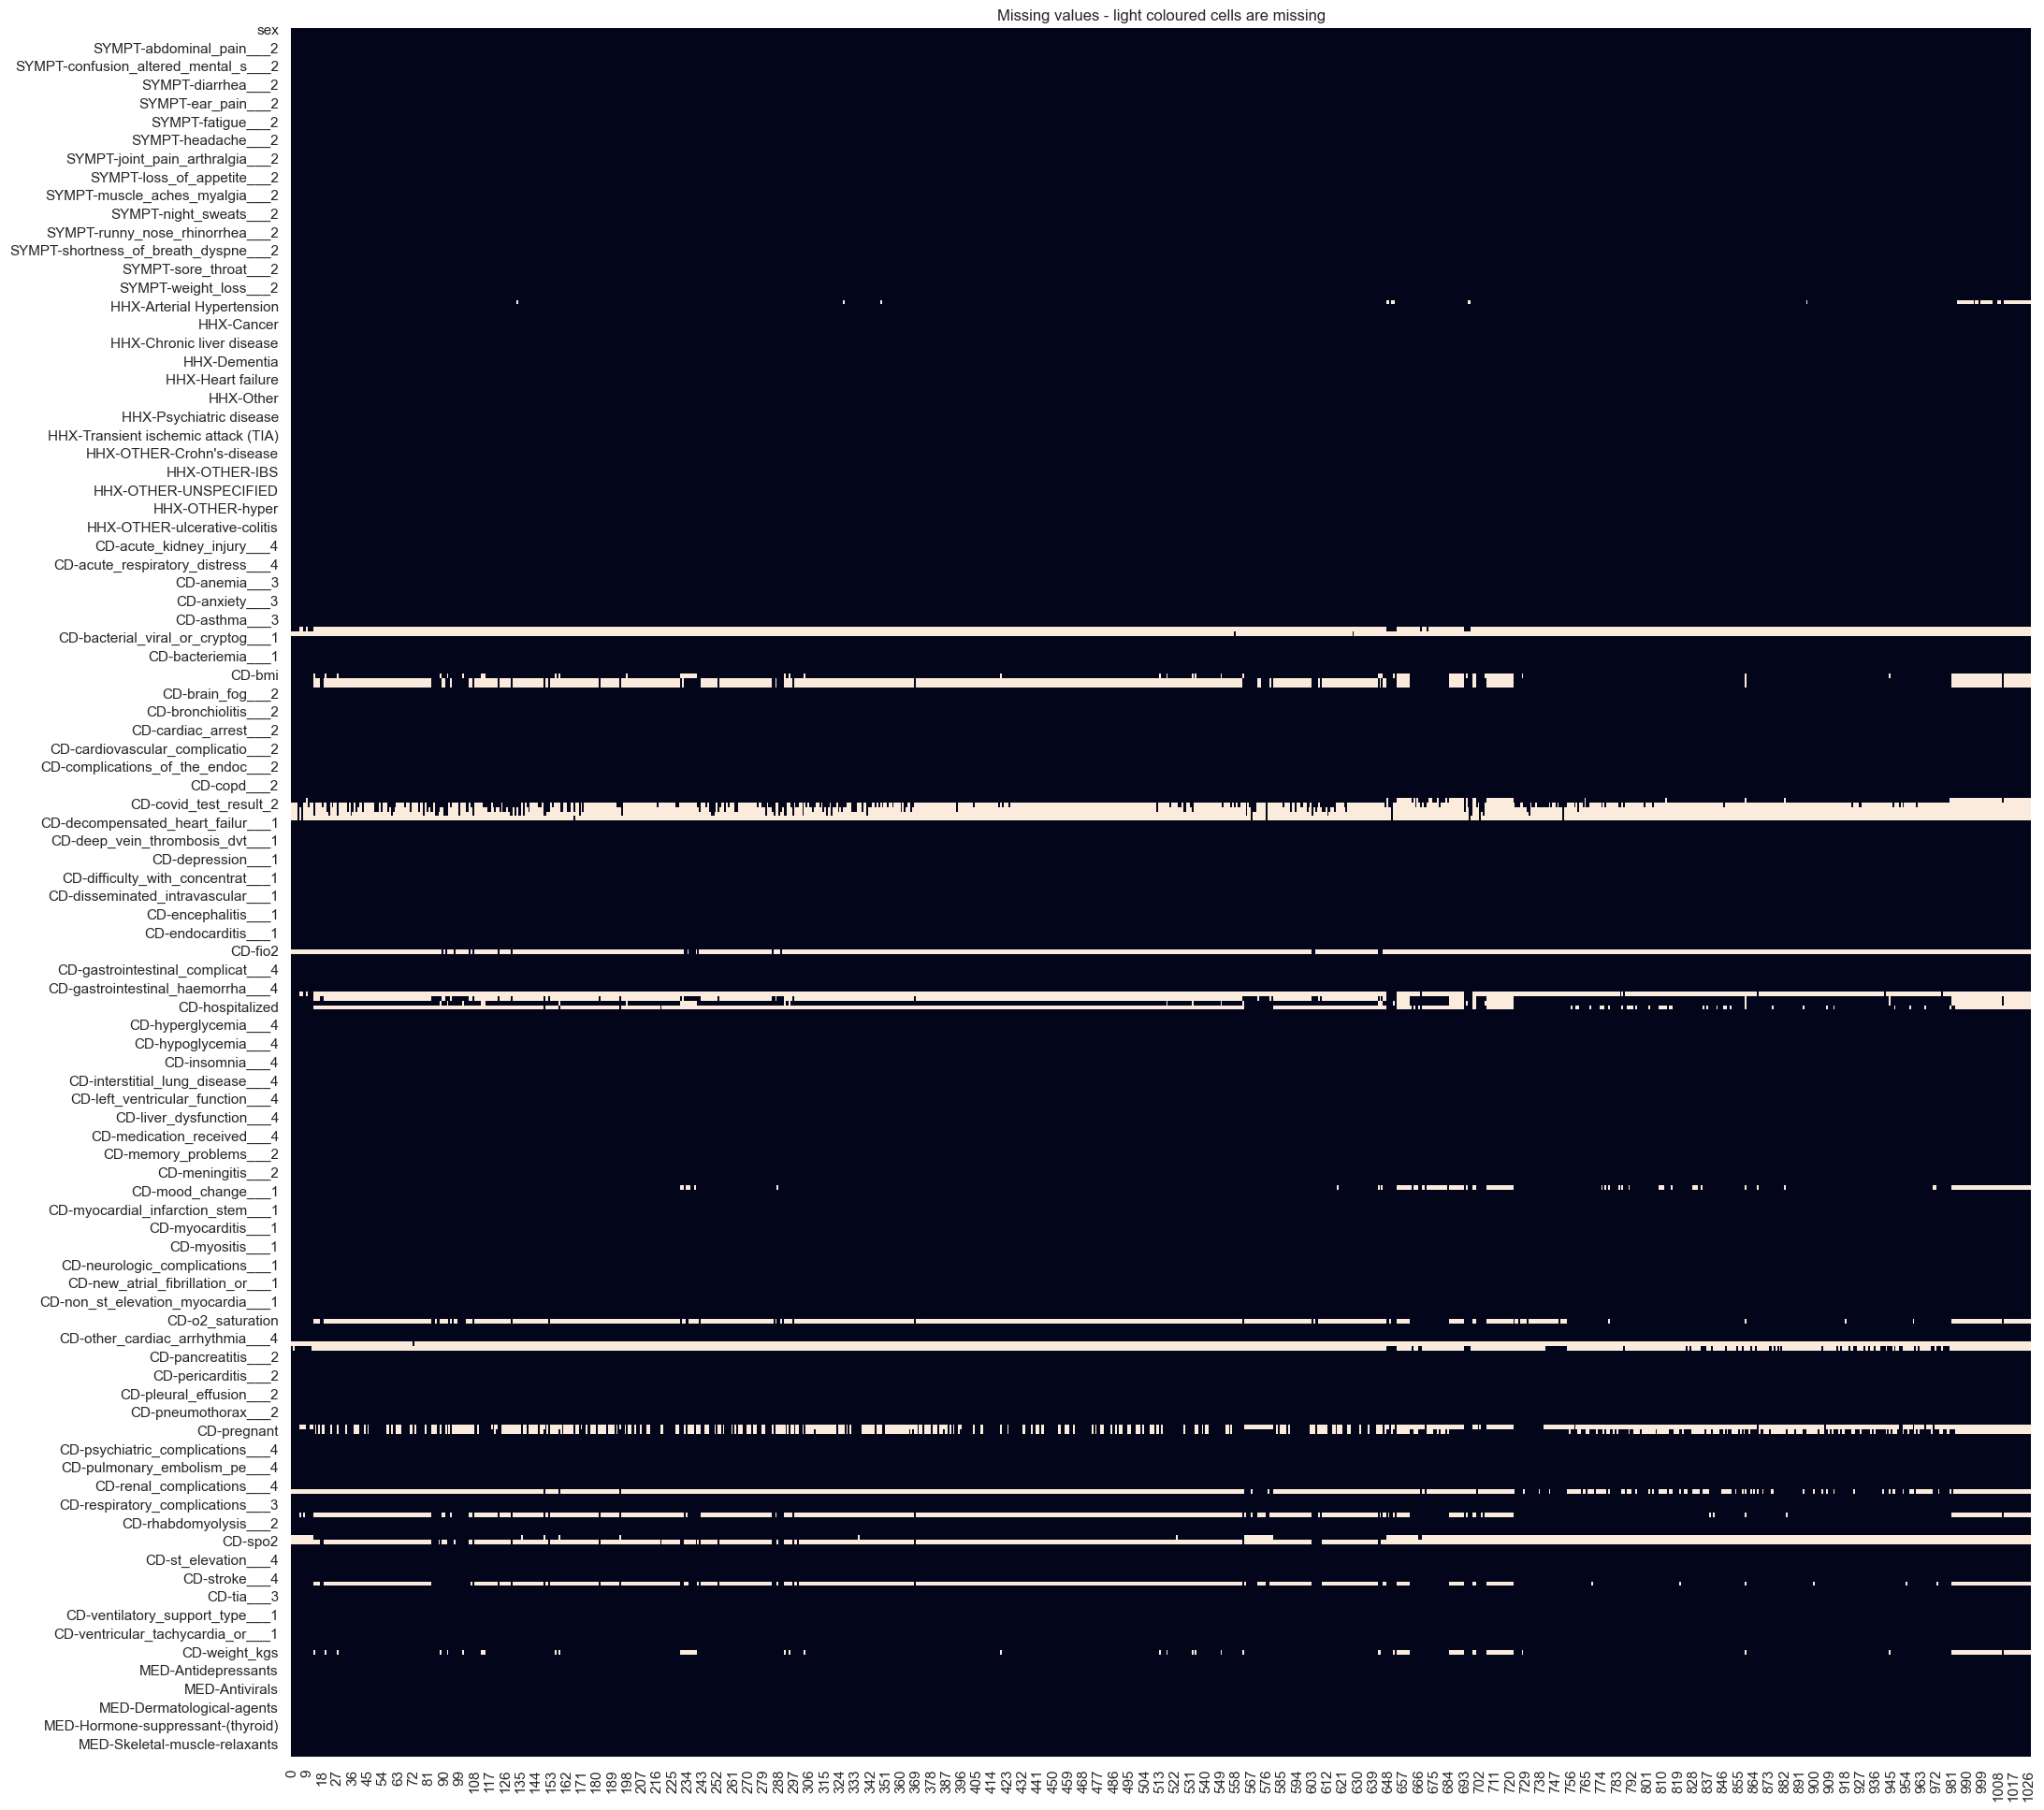

In [97]:
fig, ax = plt.subplots(figsize=(24, 24))

sns.heatmap(features.isnull().T, cbar=False, ax = ax)

plt.title("Missing values - light coloured cells are missing")

In [98]:

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

fn = p / f"1028-features-{features.shape[1]}-{today}.arrow"

# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features)
ds.save_to_disk(fn)

Saving the dataset (0/1 shards):   0%|          | 0/1028 [00:00<?, ? examples/s]

In [99]:
features

,sex,age,dag,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,...,MED-Gastrointestinal-agents,MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants,Sample_Label_ID,LC_STATUS
0,1.0,47.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1,0,0,0,0,0,0,0,LDN-0001,1.0
1,2.0,37.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,1,0,0,1,0,LDN-0002,1.0
2,2.0,54.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,0,LDN-0003,1.0
3,1.0,78.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,LDN-0004,1.0
4,2.0,33.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,LDN-0005,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,2.0,63.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,HC-0012,2.0
1024,2.0,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,HC-0013,2.0
1025,2.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,HC-0014,2.0
1026,2.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,HC-0015,2.0


## Sample Labels

In [100]:
# get the record_id using these indices

# get the record_id using these indices
sample_labels = pd.DataFrame(df.loc[features.index, "Sample_Label_ID"])

In [101]:
fn = p / "1028-sample-labels.arrow"

# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(sample_labels)
ds.save_to_disk(fn)

Saving the dataset (0/1 shards):   0%|          | 0/1028 [00:00<?, ? examples/s]

## TIME SERIES


In [139]:
months = df["Months_Post_Onset_30.44"]

# round the months to the nearest integer
months = months.round()




# months = pd.DataFrame(df.loc[features.index, "Sample_Label_ID"])

# bin the months
bins = [3, 6, 12, 24, 36, 48]
labels = ['3-6', '6-12', '12-24', '24-36', '>36']
labels = [1,2,3,4,5]

months_binned = pd.cut(months, bins = bins, labels = labels, right = False)

# rename the column
months_binned = months_binned.rename("Months_Binned")


In [140]:
min(months)

3.0

In [141]:
# join with Samle_Label_ID
months_binned = pd.concat([months_binned, sample_labels], axis = 1)

# rename Sample_Label_ID to SL
months_binned = months_binned.rename(columns = {"Sample_Label_ID": "SL"})

# reset index to SL
months_binned = months_binned.set_index("SL")


months_binned

,Months_Binned
SL,
LDN-0001,2
LDN-0002,2
LDN-0003,2
LDN-0004,4
LDN-0005,5
...,...
HC-0012,NaN
HC-0013,NaN
HC-0014,NaN


In [142]:
# add bin labels

months_binned["Bin_Labels"] = months_binned["Months_Binned"].map({1: '3-6', 
                                                                  2: '6-12', 
                                                                  3: '12-24',
                                                                  4: '24-36',
                                                                  5: '>36'})

In [143]:
months_binned.value_counts()

Months_Binned  Bin_Labels
1              3-6           202
2              6-12          156
3              12-24          66
5              >36            62
4              24-36          37
Name: count, dtype: int64

In [144]:
fn = p / "1028-time-bins.xlsx"

# save as an excel file
months_binned.to_excel(fn)



In [145]:
months_binned.dtypes

Months_Binned    category
Bin_Labels       category
dtype: object